In [220]:
#1) 10 % på rigtig model (gauss)
#2) Evaluation: f-score, mse, acc. for både liar og bigcorp. Både val og test
#3) Conclusion: visualizer alt i rapport
#4) Hvorfor er simple logistic model så god? Fjern preprocces

# Importing all packages

In [221]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cleantext import clean
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.pyplot import bar
from matplotlib.pyplot import xticks
from matplotlib.pyplot import show
from sklearn.ensemble import RandomForestClassifier
import csv
from nltk.stem import PorterStemmer
import warnings
import pickle
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonmork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Getting The news_cleaned csv and train, val, test

In [222]:
#Getting News_cleaned_2018_02_13
csv_textfilereader = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/news_cleaned_2018_02_13.csv', chunksize=1000000, iterator=True)
#big_df_1 = csv_textfilereader.get_chunk(1000000)
#big_df_2 = csv_textfilereader.get_chunk()

#first_article = big_df.iloc[0]
#print(first_article)

In [223]:
# Get Liar train datataset
print("Getting liar train csv...")
LiarTrain = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/train.tsv', sep='\t')
# Save the third column as a list
LiarTrainArticles = LiarTrain.iloc[:, 2].values.tolist()
LiarTrainLables = LiarTrain.iloc[:, 1].values.tolist()
print(LiarTrainArticles[0])
print(LiarTrainLables[0])

Getting liar train csv...
When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
half-true


In [224]:
# Get Liar Val datataset
print("Getting liar val csv...")
LiarVal = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/valid.tsv', sep='\t')



Getting liar val csv...


In [225]:
# Get Liar test datataset
print("Getting liar test csv...")
LiarTest = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/liar_dataset/test.tsv', sep='\t')




print(type(LiarTest))
# Save the third column as a list
LiarTestArticles = LiarTest.iloc[:, 2].values.tolist()
LiarTestLables = LiarTest.iloc[:, 1].values.tolist()
print(LiarTestArticles[0])
print(LiarTestLables[0])


Getting liar test csv...
<class 'pandas.core.frame.DataFrame'>
Wisconsin is on pace to double the number of layoffs this year.
false


# Defining all the functions we need

#### The cleantext function specifications

In [226]:
# Define settings for cleaning
def clean_text(text):
    """Calls the clean function from cleantext clean on a string"""
    t = clean(text,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,         # fully strip line breaks as opposed to only normalizing them NOT WORKING?
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="URL",
    replace_with_email="EMAIL",
    replace_with_phone_number="PHONE",
    replace_with_number="NUM",
    replace_with_digit="0",
    replace_with_currency_symbol="CUR",
    lang="en",                       # set to 'de' for German special handling
    )
    return t


pd.set_option("display.max_colwidth", 10000000)    
print("Done")    

Done


#### The clean function for a df column

In [227]:
    # Clean dataframe function
def clean_df(df, label, chunk_nr):
        column_names = list(df.columns)

        # unique words and num before clean
        words = df[label].str.split().explode()
        unique_words_before = set(words)
        
        # Count the number of words in the list
        total_word_count_before = len(words)
        #print("Total word count before clean: ", total_word_count_before, "\n")


        print("Cleaning chunk: ", chunk_nr)
        df[label] = df[label].apply(clean_text)

        words_clean = df[label].str.split().explode()
        unique_words_clean = set(words_clean)
        total_word_count_clean = len(words_clean)


        print("Tokenizing and removing stopwords for chunk: ", chunk_nr)
        stop_words = set(stopwords.words('english'))
        df[label] = df[label].apply(nltk.word_tokenize)
        df[label] = df[label].apply(lambda row: [w for w in row if w not in stop_words])
        
        unique_words_stop = df[label].explode().unique()
        #unique_words_stop = len(unique_words_stop)
        total_word_count_stop = df[label].explode().count()

    
        print("Stemming chunk nr:", chunk_nr)
        porter = PorterStemmer()
        df[label] = df[label].apply(lambda row: [porter.stem(w) for w in row])


        unique_words_stem = df[label].explode().unique()
        #unique_words_stem = len(unique_words_stem)
        total_word_count_stem = df[label].explode().count()

        


        print("Done with chunk: ", chunk_nr, "\n")


        return df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem, total_word_count_before, total_word_count_clean, total_word_count_stop, total_word_count_stem
        


#### Function to vectorize a set and unique words to get same dimensions
##### X_vectoriser is a function that takes in a list of text data as input, concatenates the words in each string, and transforms the resulting text data into a sparse matrix representation using the CountVectorizer from scikit-learn. The resulting matrix can be used as input to machine learning algorithms.

In [228]:
def X_vectoriser(vectee, unique_words):
    vectee = [' '.join(words) for words in vectee]
    vectorizer = CountVectorizer(vocabulary=unique_words)
    vectee = vectorizer.fit_transform(vectee)
    return vectee

#### Function to make the labels binary.
##### make_bin is a function that takes in a list of categorical data and converts it into a list of binary labels. The function iterates through the input list and assigns a binary label of 0 to each non-'fake' element and a label of 1 to each 'fake' element. The resulting binary labels are returned as a list, which can be used as target values for machine learning algorithms.

In [229]:
def make_bin(to_bin):
    to_bin = np.asarray(to_bin)
    reliable = 0
    fake = 0
    bin_list = []
    for i in range(len(to_bin)):
        if to_bin[i] == "nan":
            print("nan")
        if to_bin[i] == "Na":
            print("Na")
        if to_bin[i] != 'fake' and to_bin[i] != 'satire' and to_bin[i] != 'conspiracy' and to_bin[i] != 'junksci' and to_bin[i] != 'hate' and to_bin[i] != 'clickbait' and to_bin[i] != 'unreliable' and to_bin[i] != 'rumor' and to_bin[i] != 'false' and to_bin[i] != 'pants-fire' and to_bin[i]!='nan':
            bin_list.append(0)
            reliable = reliable +1
        else:
            bin_list.append(1)
            fake = fake+1
        #print(to_bin[i])
    return bin_list, fake, reliable

In [230]:
def remove_duplicates_and_nan(df, label1, label2):

    # Count the number of articles before 
    n_articles_before = df.shape[0]
    
    # Remove rows with NaN in the specified column
    n_articles_removed_NA = n_articles_before - df.dropna(subset=[label1]).shape[0]
    df = df.dropna(subset=[label2])
    
    # Drop duplicates based on the specified column
    df.drop_duplicates(subset=[label1], keep='first', inplace=True)

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)
    
    # Count the number of articles after
    n_articles_after = df.shape[0]
    
    # Calculate the number of articles that were removed
    n_articles_removed_duplicates = n_articles_before - n_articles_after - n_articles_removed_NA

    # Print the number of articles removed
    print(f"Removed {n_articles_removed_NA} articles due to NaN values.")
    print(f"Removed {n_articles_removed_duplicates} articles due to duplicates.\n")
    
    
    return df

#### How to save data to csv file

In [231]:
""" # Save original data to CSV
first_chunk.to_csv('original_data.csv', index=False)

# Clean the data
cleaned_df = clean_df(first_chunk)

# Save cleaned data to CSV
cleaned_df.to_csv('cleaned_data.csv', index=False) """

" # Save original data to CSV\nfirst_chunk.to_csv('original_data.csv', index=False)\n\n# Clean the data\ncleaned_df = clean_df(first_chunk)\n\n# Save cleaned data to CSV\ncleaned_df.to_csv('cleaned_data.csv', index=False) "

## The big Dataset

#### Cleaning the big dataset

In [232]:
unique_words_before_big = set()
unique_words_clean_big = set()
unique_words_stop_big = set()
unique_words_stem_big = set()

total_word_count_before_big = 0
total_word_count_clean_big = 0
total_word_count_stop_big = 0
total_word_count_stem_big = 0

size = 1000
get_chunk_size = 100

all_of_df = csv_textfilereader.get_chunk(size)

#Removing duplicates and Na/nan from big dataset 
all_of_df = remove_duplicates_and_nan(all_of_df, 'title', 'content')

chunks = [all_of_df.iloc[j:j+get_chunk_size] for j in range(0, size, get_chunk_size)]
chunk_nr = 0
for chunk in chunks:
    chunk_nr += 1
    df, unique_words_before, unique_words_clean, unique_words_stop, unique_words_stem, total_word_count_before, total_word_count_clean, total_word_count_stop, total_word_count_stem = clean_df(chunk, 'content', chunk_nr)
    df = df.fillna(value={"content": "UNKNOWN", "type": "UNKNOWN"})

    df.to_csv('big_df.csv', mode='a', index=False, quoting=csv.QUOTE_ALL)

    unique_words_before_big.update(unique_words_before)
    unique_words_clean_big.update(unique_words_clean)
    unique_words_stop_big.update(unique_words_stop)
    unique_words_stem_big.update(unique_words_stem)

    total_word_count_before_big += total_word_count_before
    total_word_count_clean_big += total_word_count_clean
    total_word_count_stop_big += total_word_count_stop
    total_word_count_stem_big += total_word_count_stem



with open('unique_words_before_big.pkl', 'wb') as f:
    pickle.dump(unique_words_before_big, f)

with open('unique_words_clean_big.pkl', 'wb') as f:
    pickle.dump(unique_words_clean_big, f)
    
with open('unique_words_stop_big.pkl', 'wb') as f:
    pickle.dump(unique_words_stop_big, f)

with open('unique_words_stem_big.pkl', 'wb') as f:
    pickle.dump(unique_words_stem_big, f)


count_list = [total_word_count_before_big, total_word_count_clean_big, total_word_count_stop_big, total_word_count_stem_big]
with open('counts.pkl', 'wb') as f:
    pickle.dump(count_list, f)






Removed 0 articles due to NaN values.
Removed 104 articles due to duplicates.

Cleaning chunk:  1
Tokenizing and removing stopwords for chunk:  1
Stemming chunk nr: 1
Done with chunk:  1 

Cleaning chunk:  2
Tokenizing and removing stopwords for chunk:  2
Stemming chunk nr: 2
Done with chunk:  2 

Cleaning chunk:  3
Tokenizing and removing stopwords for chunk:  3
Stemming chunk nr: 3
Done with chunk:  3 

Cleaning chunk:  4
Tokenizing and removing stopwords for chunk:  4
Stemming chunk nr: 4
Done with chunk:  4 

Cleaning chunk:  5
Tokenizing and removing stopwords for chunk:  5
Stemming chunk nr: 5
Done with chunk:  5 

Cleaning chunk:  6
Tokenizing and removing stopwords for chunk:  6
Stemming chunk nr: 6
Done with chunk:  6 

Cleaning chunk:  7
Tokenizing and removing stopwords for chunk:  7
Stemming chunk nr: 7
Done with chunk:  7 

Cleaning chunk:  8
Tokenizing and removing stopwords for chunk:  8
Stemming chunk nr: 8
Done with chunk:  8 

Cleaning chunk:  9
Tokenizing and removin

#### retrieve the dataframe stored in big_df, the lists of unique words and the total and unique word counts.

In [233]:
def convert_to_list(x):
    return x.split(',')

big_df = pd.read_csv('/Users/simonmork/Desktop/GitHub/FinalProjectDS/big_df.csv', chunksize=size, iterator=True, converters={'content': convert_to_list})
big_df = big_df.get_chunk(size)

In [234]:
with open('unique_words_before_big.pkl', 'rb') as f:
    unique_words_before_big_taken = pickle.load(f)

with open('unique_words_clean_big.pkl', 'rb') as f:
    unique_words_clean_big_taken = pickle.load(f)

with open('unique_words_stop_big.pkl', 'rb') as f:
    unique_words_stop_big_taken = pickle.load(f)

with open('unique_words_stem_big.pkl', 'rb') as f:
    unique_words_stem_big_taken = pickle.load(f)

with open('counts.pkl', 'rb') as f:
    count_list = pickle.load(f)


total_word_count_before_big = count_list[0]
total_word_count_clean_big = count_list[1]
total_word_count_stop_big = count_list[2]
total_word_count_stem_big = count_list[3]


#### Getting some stats on the big dataset

In [235]:
#Part 1 - Task 2
print("Counting number of urls, dates and num, and fake news and trump")
url = 0
num = 0
trump=0
fakenews = 0
notfake = 0


for index, row in big_df.iterrows():
    for word in big_df.at[index,'content']:
        #print(word)
        if word == 'url':
            url = url+1
        if word == 'num':
            num = num+1
        if word == 'trump':
            trump = trump+1
    if big_df.at[index,'type'] == 'fake':
        fakenews = fakenews+1
    else:
        notfake = notfake+1
print("Num urls: ", url)
print("Num num: ", num)
print("Num trump: ", trump)
print("Num fake: ", fakenews)
print("Num notfake: ", notfake)

Counting number of urls, dates and num, and fake news and trump
Num urls:  0
Num num:  0
Num trump:  0
Num fake:  133
Num notfake:  867


Visualization of the key properties of the dataset

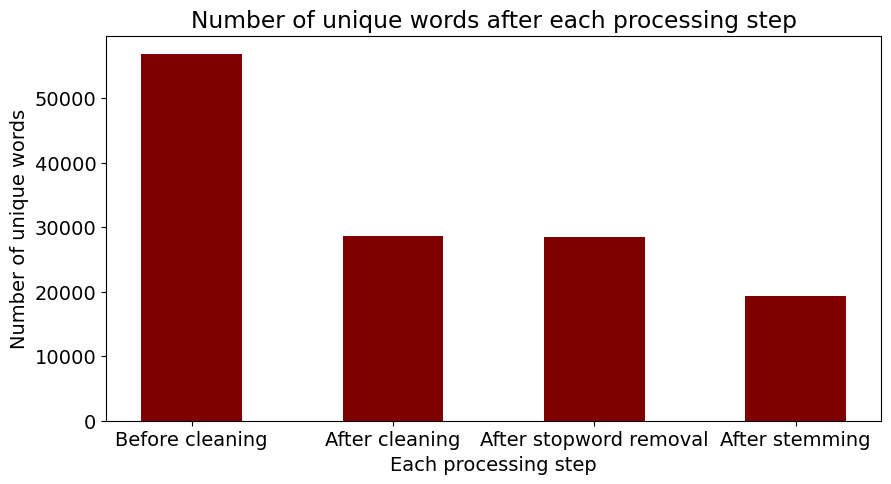

In [236]:
# Plotting the bar chart 
data = {'Before cleaning': len(unique_words_before_big), 'After cleaning': len(unique_words_clean_big), 'After stopword removal': len(unique_words_stop_big), 'After stemming': len(unique_words_stem_big)}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('Each processing step')
plt.ylabel('Number of unique words')
plt.title('Number of unique words after each processing step')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

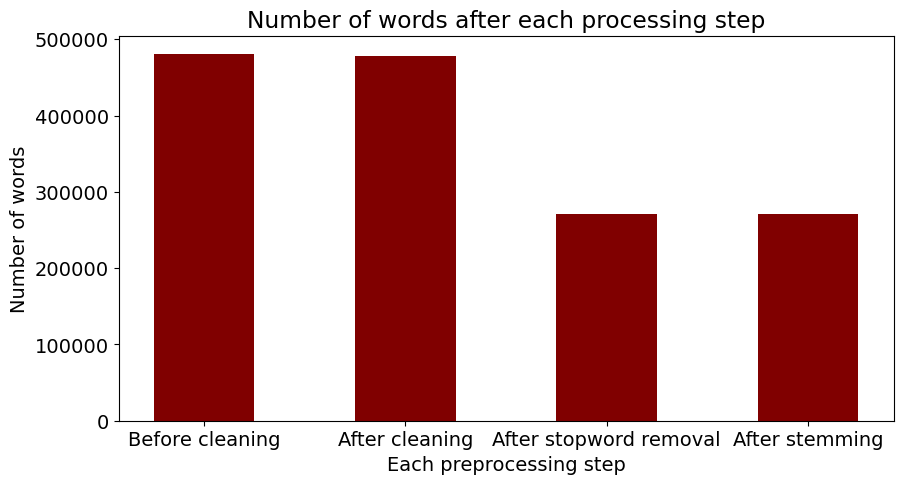

In [237]:
# Plotting the bar chart 
data = {'Before cleaning': total_word_count_before_big, 'After cleaning': total_word_count_clean_big, 'After stopword removal': total_word_count_stop_big, 'After stemming': total_word_count_stem_big}
dataset = list(data.keys())
values = list(data.values())
bar(dataset, values, color = 'maroon', width = 0.5)
plt.xlabel('Each preprocessing step')
plt.ylabel('Number of words')
plt.title('Number of words after each processing step')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

#### Splitting the data
##### This code splits a DataFrame df into training, validation, and testing sets, with a 80:10:10 ratio. The X variable contains the content of the articles, while the y variable contains the type of the articles (reliable/fake).

In [238]:
X, y = big_df.content, big_df['type']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)


#### Transform text big csv data into a sparse matrix representation
##### To make predictions later

In [239]:
X_train_vec = X_vectoriser(X_train, unique_words_stem_big)
X_val_vec = X_vectoriser(X_val, unique_words_stem_big)
X_test_vec = X_vectoriser(X_test, unique_words_stem_big)

### Handling the labels for big data

In [240]:
y_train_bin, LabelFa, LabelRe  = make_bin(y_train)
y_val_bin, no1, no2 = make_bin(y_val)
y_test_bin, no3, no4 = make_bin(y_test)


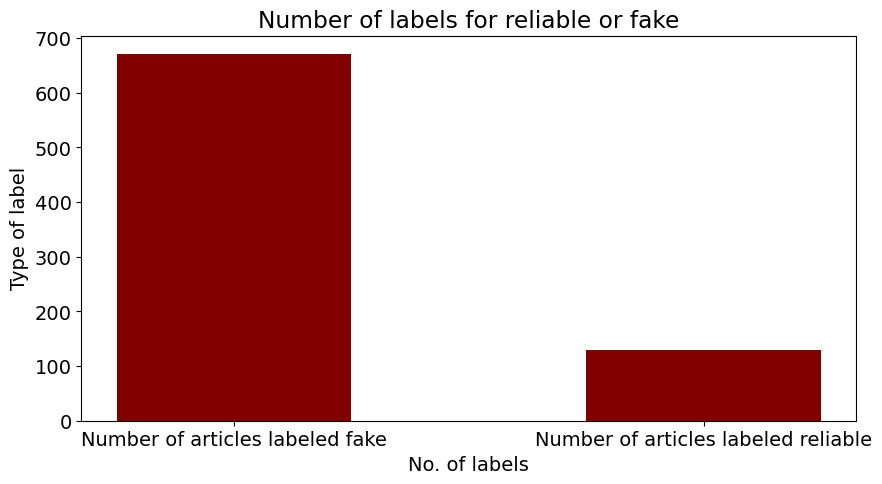

In [241]:
# Bar chart showing number of fake labels and number of reliable
data = {'Number of articles labeled fake': LabelFa, 'Number of articles labeled reliable': LabelRe }
labels = list(data.keys())
values = list(data.values())
bar(labels, values, color = 'maroon', width= 0.5)
plt.xlabel('No. of labels')
plt.ylabel('Type of label')
plt.title('Number of labels for reliable or fake')
plt.rcParams["figure.figsize"] = [10.0, 5.0]
font = {'size' : 14}
plt.rc('font', **font)
plt.show()

## The Liar dataset

#### Cleaning the Liar dataset

In [242]:
# Removing duplicates and Na/nan from liar datasets

LiarTest.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
LiarTest = remove_duplicates_and_nan(LiarTest, 'title', 'content')

LiarVal.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
LiarVal = remove_duplicates_and_nan(LiarVal, 'title', 'content')

LiarTrain.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
LiarTrain = remove_duplicates_and_nan(LiarTrain, 'title', 'content')

Removed 0 articles due to NaN values.
Removed 534 articles due to duplicates.

Removed 0 articles due to NaN values.
Removed 549 articles due to duplicates.

Removed 2 articles due to NaN values.
Removed 6409 articles due to duplicates.



In [243]:
#X_val_liar, k1, k2,k3, UWC = clean_df(LiarVal, 2)
LiarVal.columns = ['col1', 'label', 'content', 'title', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
#LiarVal = LiarVal.rename(columns={2: 'content'})
#print("Headers: ", LiarVal.columns.values)
#print(LiarVal)
Liar_df, unique_words_before_liar, unique_words_clean_liar, unique_words_stop_liar, unique_words_stem_liar, total_word_count_liar, total_word_count_liar, total_word_count_liar, total_word_count_liar = clean_df(LiarVal, 'content', 1)

Cleaning chunk:  1
Tokenizing and removing stopwords for chunk:  1
Stemming chunk nr: 1
Done with chunk:  1 



#### Vectorizing the liar datset

In [244]:
X_val_liar = X_vectoriser(Liar_df.content, unique_words_stem_big)

#### Making the labels for liar dataset binary

In [245]:
y_val_liar, no5, no6 = make_bin(Liar_df.label)

#### Getting fake and reliable for liar. This lets us see if we overfit by just predicting fake.

In [246]:
fake = 0
reliable = 0
for elm in y_val_liar:
    if elm == 1:
        fake +=1
    else:
        reliable +=1
print("reliable: ", reliable)
print("unreliable: ", fake)
print("percent fake: ", fake/(reliable+fake))

reliable:  520
unreliable:  214
percent fake:  0.29155313351498635


## Models:

### A simple logistic model:

#### Training on FakeNewsCorpus and predicting on the FakeNewsCorpus val dataset

In [247]:
simple_log_model = LogisticRegression(max_iter=100000)
simple_log_model.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model.predict(X_val_vec)

acc_simple_log = accuracy_score(y_val_bin, y_pred)
print("Accuracy of simple logistic regression: ", acc_simple_log)


Accuracy of simple logistic regression:  0.93


#### Predicting the simple log model on the liar validation set: 

In [248]:
y_pred = simple_log_model.predict(X_val_liar)

acc_simple_log_liar = accuracy_score(y_val_liar, y_pred)
print(accuracy_score(y_val_liar, y_pred))

0.29155313351498635


### Simlpe logistic model with meta (author and domain)

#### Make the data include the authors and domains

In [249]:

for index, row in big_df.iterrows():
    #print("df.at[index,'authors']", df.at[index,'authors'])
    if big_df.at[index,'authors'] != "nan":
        split_str = str(big_df.at[index,'authors']).split(", ")
        for word in split_str:
            author_str = "author: " + word.lower()
            big_df.at[index,'content'].append(author_str)
    if  big_df.at[index,'domain'] != "nan":
        domain_str = "domain: " + str(big_df.at[index,'domain'])
        big_df.at[index,'content'].append(domain_str.lower())
    

#print(df['content'][1])

X_meta, y_meta = big_df.content, big_df['type']


X_train_meta, X_temp_meta, y_train_meta, y_temp_meta = train_test_split(X_meta, y_meta, test_size = 0.2, random_state = 0)
X_test_meta, X_val_meta, y_test_meta, y_val_meta = train_test_split(X_temp_meta, y_temp_meta, test_size = 0.5, random_state = 0)

X_train_vec_meta = X_vectoriser(X_train_meta, unique_words_stem_big)
X_val_vec_meta = X_vectoriser(X_val_meta,unique_words_stem_big)
X_test_vec_meta = X_vectoriser(X_test_meta, unique_words_stem_big)

y_train_bin_meta, LabelFa, LabelRe  = make_bin(y_train_meta)
y_val_bin_meta, LabelFa, LabelRe  = make_bin(y_val_meta)
y_test_bin_meta, LabelFa, LabelRe = make_bin(y_test_meta)



#### Predict with simple model and meta

In [250]:
simple_log_model_meta = LogisticRegression(max_iter=100000)
simple_log_model_meta.fit(X_train_vec_meta, y_train_bin_meta)
y_pred_meta = simple_log_model_meta.predict(X_val_vec_meta)

acc_simple_log_meta = accuracy_score(y_val_bin_meta, y_pred_meta)
print(accuracy_score(y_val_bin_meta, y_pred_meta))

0.96


#### Comparing the simple model without metadata and the simple model with metadata:

In [251]:
#Comparison of acc bewteen simple log models

acc_diff_logs = abs(acc_simple_log_meta - acc_simple_log)
print(acc_diff_logs)

0.029999999999999916


### Gaussion naive baiers model: (kan ikke køre med lige så meget data som den logistiske)


In [252]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec.toarray(), y_train_bin)

# train the model on the resampled data
simple_nb_model = GaussianNB()
simple_nb_model.fit(X_train_resampled, y_train_resampled)

# make predictions on the validation data
y_pred_gauss = simple_nb_model.predict(X_val_vec.toarray())

# evaluate the accuracy of the model's predictions
acc_gauss = accuracy_score(y_val_bin, y_pred_gauss)
print(accuracy_score(y_val_bin, y_pred_gauss))


0.65


#### predicting the gaussian model on the liar dataset

In [253]:
y_pred_gauss_liar = simple_nb_model.predict(X_val_liar.toarray())

# evaluate the accuracy of the model's predictions on liar
acc_gauss_liar = accuracy_score(y_val_liar, y_pred_gauss_liar)
print(acc_gauss_liar)

0.4196185286103542


#### making and predicting for the Gaussian model with meta

In [254]:
# create a RandomUnderSampler instance
rus_meta = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled_meta, y_train_resampled_meta = rus_meta.fit_resample(X_train_vec_meta.toarray(), y_train_bin_meta)

# train the model on the resampled data
simple_nb_model_meta = GaussianNB()
simple_nb_model_meta.fit(X_train_resampled_meta, y_train_resampled_meta)

# make predictions on the validation data
y_pred2_meta = simple_nb_model_meta.predict(X_val_vec_meta.toarray())

# evaluate the accuracy of the model's predictions
acc_gaus_meta = accuracy_score(y_val_bin_meta, y_pred2_meta)
print(accuracy_score(y_val_bin_meta, y_pred2_meta))

0.74


#### Comparing the gaussian with and without metadata

In [255]:
#Comparison of acc between simple gauss models
#Frst run randomstate=42: 0.038000000000000034
#Second run, randomstate=0: 0.04

acc_diff_gauss = abs(acc_gauss - acc_gaus_meta)
print(acc_diff_gauss)

0.08999999999999997


#### Random forrest classifer model:

In [256]:
# RandomForest model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer


# Train a Random Forest model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_vec, y_train_bin)
print("Model is trained")

#output notes: Accuracy: 0.764 when nrows=10.000, runtime 47.8s
#output notes: Accuracy: 0.8575 when nrows=20.000, runtime 1m 53.3s



Model is trained


#### Evaluate the forrest model on the validation for the big fake news corpus

In [257]:
# Evaluate the model on big corpus
y_pred_forrest = rfc.predict(X_val_vec)
acc_forrest = accuracy_score(y_val_bin, y_pred_forrest)
print('Accuracy:', acc_forrest)

Accuracy: 0.92


#### Evaluate the forrest model on liar valid 

In [258]:
# Evaluate the model on liar corpus
y_pred_forrest_liar = rfc.predict(X_val_liar)
acc_forrest = accuracy_score(y_val_liar, y_pred_forrest_liar)
print('Accuracy:', acc_forrest)

Accuracy: 0.29291553133514986


#### Evaluate the forrest model on big corpus with included metadata

In [259]:
# Train and evaluate the model on liar corpus
rfc.fit(X_train_vec_meta, y_train_bin_meta)
y_pred_forrest_meta = rfc.predict(X_val_vec)
acc_forrest = accuracy_score(y_val_bin, y_pred_forrest_meta)
print('Accuracy:', acc_forrest)

Accuracy: 0.93


#### Support vector machine model:

In [260]:
# Support Vector Machine (SVM) model
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Train an SVM model
svm = SVC(kernel='linear')
svm.fit(X_train_vec, y_train_bin)
print("Model is trained")

#Output note: Accuracy: 0.575, when nrows=1.000, runtime 41.3s
#Output note: Accuracy: 0.62, when nrows=2.000, runtime 1m 42.7s
#Output note: Accuracy: 0.6633, when nrows=3.000, runtime 3m 31.6s
#Output note: Accuracy: 0.67, when nrows=4.000, runtime 7m 31.5s
#Output note: Accuracy: 0.684, when nrows=5.000, runtime 12min 30s
#Output note: Accuracy: 0.7125, when nrows=6.000, runtime 53min 29.7s
#Output note: Accuracy: 0.767, when nrows=10.000, runtime 7h 12min 11.4s


Model is trained


In [261]:
# Evaluate the model on big corpus
y_pred_svm = svm.predict(X_val_vec)
acc_svm = accuracy_score(y_val_bin, y_pred_svm)
print('Accuracy:', acc_svm)

Accuracy: 0.9


In [262]:
# Evaluate the model on liar corpus
y_pred_svm_liar = rfc.predict(X_val_liar)
acc_svm = accuracy_score(y_val_liar, y_pred_svm_liar)
print('Accuracy:', acc_svm)

Accuracy: 0.29155313351498635


## DEN KOMPLICEREDE MODEL schematic:

Accuracy for C=0.1: 0.86
Best C: 0.1
              precision    recall  f1-score   support

           0       0.54      0.94      0.68        16
           1       0.99      0.85      0.91        84

    accuracy                           0.86       100
   macro avg       0.76      0.89      0.80       100
weighted avg       0.91      0.86      0.87       100



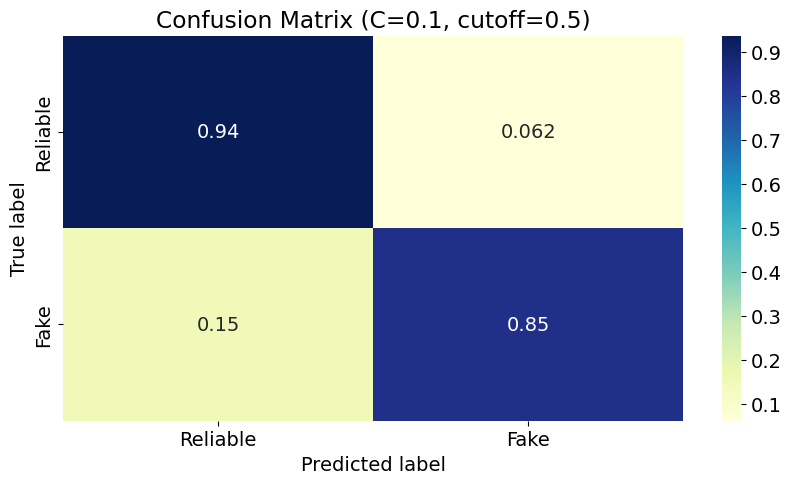

In [263]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

Cs = [0.1]
best_accuracy = 0
best_c = 0
best_y_pred = None

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec, y_train_bin)

for c in Cs:
    simple_log_model = LogisticRegression(max_iter=100000, C=c, class_weight='balanced')
    simple_log_model.fit(X_train_resampled, y_train_resampled)
    y_pred = simple_log_model.predict(X_val_vec)
    accuracy = accuracy_score(y_val_bin, y_pred)
    print(f"Accuracy for C={c}: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c
        best_y_pred = y_pred

print("Best C:", best_c)

# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix (C={best_c}, cutoff={cutoff})')
plt.show()


<AxesSubplot:>

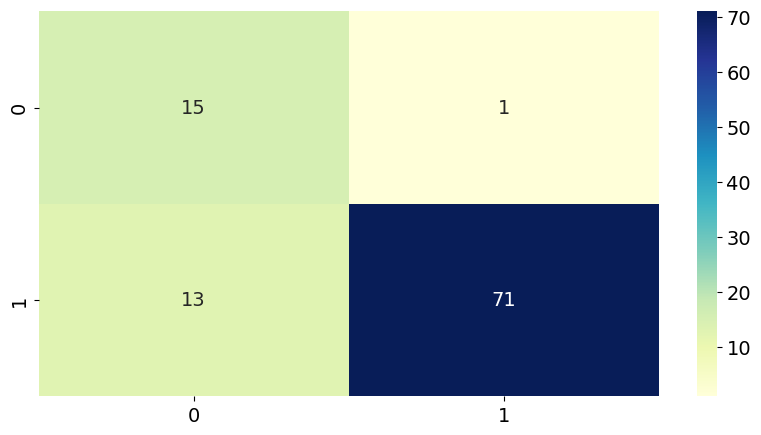

In [264]:
# calculate and plot confusion matrix with absolute values
conf_mat1 = confusion_matrix(y_val_bin, best_y_pred)
sns.heatmap(conf_mat1, annot=True, cmap="YlGnBu")

In [265]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec.toarray(), y_train_bin)

# train the model on the resampled data
simple_nb_model = GaussianNB()
simple_nb_model.fit(X_train_resampled, y_train_resampled)

GaussianNB()

#### Predict the advanced guassian model on the FakeNewsCorpus

In [266]:
# make predictions on the validation data
y_pred_gauss = simple_nb_model.predict(X_val_vec.toarray())

# evaluate the accuracy of the model's predictions
acc_gauss = accuracy_score(y_val_bin, y_pred_gauss)
print(accuracy_score(y_val_bin, y_pred_gauss))

0.65


#### Predictiong the advanced gaussian on the liar dataset

In [267]:
y_pred_gauss_liar = simple_nb_model.predict(X_val_liar.toarray())

# evaluate the accuracy of the model's predictions on liar
acc_gauss_liar = accuracy_score(y_val_liar, y_pred_gauss_liar)
print(acc_gauss_liar)

0.4196185286103542
